[GitHub link](https://github.com/AidMMcMillan/AidMMcMillan.github.io/blob/main/posts/blog3)

In this blog post I will be training a model to predict income categories based on certain demographic characteristics and then auditing the model to asses its bias with respect to other demographic characteristics (in this case I will be assesing bias).

# Loading and Preparing Data

In order to start working with the data, I first have to prepare it for training. In this blog post I will be using demographic data from the American Community Survey’s Public Use Microdata Sample (PUMS). This data is accesible thorugh the `folktables` package. I decided to work with Connecticut's 2018 survey data, since that is the state I am from.

In [227]:
from folktables import ACSDataSource, BasicProblem, adult_filter
import numpy as np

STATE = "CT"

data_source = ACSDataSource(survey_year="2018", 
                            horizon="1-Year", 
                            survey="person")

acs_data = data_source.get_data(states=[STATE], download=True)

This is how that the first few rows of that data look:

In [228]:
acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000191,1,1,302,1,9,1013097,40,90,...,82,39,38,81,0,38,0,0,36,34
1,P,2018GQ0000285,1,1,101,1,9,1013097,70,18,...,69,134,7,70,6,68,141,68,132,145
2,P,2018GQ0000328,1,1,1101,1,9,1013097,17,54,...,37,35,16,16,0,17,18,19,18,16
3,P,2018GQ0000360,1,1,905,1,9,1013097,47,18,...,46,48,4,90,87,84,90,3,47,48
4,P,2018GQ0000428,1,1,903,1,9,1013097,35,96,...,32,35,36,71,36,3,37,2,2,35


Now I will select only the relevant features from the dataset, using the reccomendations from the [paper](https://arxiv.org/pdf/2108.04884.pdf) provided in the blog's instructions. 

In [229]:
possible_features = [
        "AGEP",
        "COW",
        "SCHL",
        "MAR",
        "OCCP",
        "POBP",
        "RELP",
        "WKHP",
        "SEX",
        "RAC1P",
    ]

acs_data[possible_features].head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,90,NaN,16.0,5,NaN,9,17,NaN,2,1
1,18,4.0,16.0,5,3550.0,36,17,18.0,2,1
2,54,NaN,17.0,5,NaN,9,17,NaN,1,2
3,18,1.0,19.0,5,4030.0,303,17,2.0,1,1
4,96,NaN,16.0,2,NaN,9,16,NaN,2,1


### Data Observations

Now that the data is ready, I will define my problem using foklore's `BasicProblem` class. Within the class I will create a target vector where 1 means the person makes avobe 50k/year and 0 means they make less than 50k/year. I also pass the data through a filter that removes any non-working adults.

In [230]:
from sklearn.model_selection import train_test_split

features_to_use = [f for f in possible_features if f not in ["PINCP", "SEX"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target="PINCP",
    target_transform=lambda x: x > 50000, # Create target vector based on 50k/year treshold
    group="SEX",
    preprocess=adult_filter, # Filter data to only include working adults
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data) # Convert data to numpy array

#Train/test split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

Now I will convert the data to a `pandas DataFrame` to dig into describe some aspects of the data set.

In [231]:
import pandas as pd

# Convert data to pandas DataFrame
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

# Calculate number of respondents
n_respondents = df.shape[0]
n_over50k = (y_train==1).sum()

print(f"Number of respondents used in model = {n_respondents}")
print(f"Percent respondents w/ income > 50k/year = {(n_over50k/n_respondents).round(4)*100}%")

Number of respondents used in model = 15828
Percent respondents w/ income > 50k/year = 48.05%


0.5481416812172611
0.41101152368758004


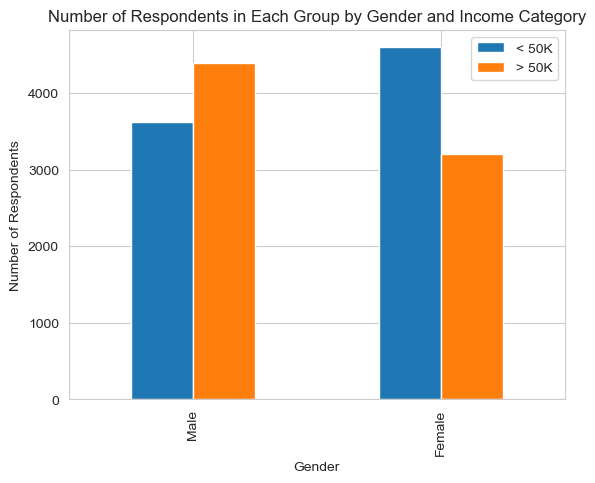

In [330]:
import seaborn as sns
import matplotlib.pyplot as plt

gender_labels = {1: "Male", 2: "Female"}

# Count the number of people in each group based on gender and income category
gb1 = df.groupby(["group", "label"]).size().unstack()

percentages = df.groupby(['group'])['label'].mean()
male_percent = percentages[1]
female_percent = percentages[2]

print(male_percent)
print(female_percent)

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = gb1.plot(kind="bar")

# Set labels and title
ax.set_xlabel('Gender')
ax.set_ylabel('Number of Respondents')
ax.set_title('Number of Respondents in Each Group by Gender and Income Category')

# Set custom tick labels for gender
ax.set_xticklabels(['Male', 'Female'])

# Set legend
ax.legend(['< 50K', '> 50K'])

# Show the plot
plt.show()

Race      Aisan     Black     Other     White
group                                        
1      0.591667  0.308411  0.248945  0.586404
2      0.449721  0.290730  0.192225  0.438585


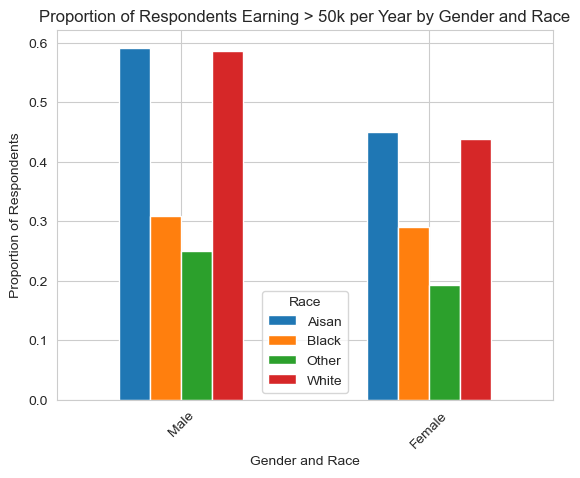

In [332]:
gender_labels = {1: 'Male', 2: 'Female'}

race_labels = {
    1: "White",
    2: "Black",
    6: "Aisan",
    **dict.fromkeys([3, 4, 5, 7, 8, 9], "Other"),
}

df['Race'] = df['RAC1P'].map(race_labels)

# Find percentage people in each gender and race group and check the percentage earning > 50k/year
gb = df.groupby(['group', 'Race'])['label'].mean().unstack()

print(gb)

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = gb.plot(kind='bar')

# Set labels and title
ax.set_xlabel('Gender and Race')
ax.set_ylabel('Proportion of Respondents')
ax.set_title('Proportion of Respondents Earning > 50k per Year by Gender and Race')

# Set custom tick labels for gender and race
ax.set_xticklabels(['Male', 'Female'], rotation=45)

# Show the plot
plt.show()

label        False  True 
group Race               
1     Aisan    147    213
      Black    370    165
      Other    356    118
      White   2750   3899
2     Aisan    197    161
      Black    505    207
      Other    374     89
      White   3524   2753


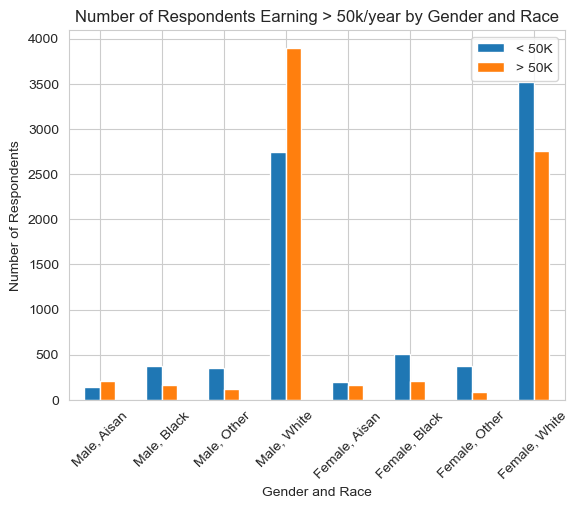

In [320]:
# Count the number of people in each group based on gender, race, and income category
group_counts = df.groupby(['group', 'Race', 'label']).size().unstack().fillna(0)

print(group_counts)

# Plot the bar chart using Seaborn
sns.set_style("whitegrid")
ax = group_counts.plot(kind='bar')

# Set labels and title
ax.set_xlabel('Gender and Race')
ax.set_ylabel('Number of Respondents')
ax.set_title('Number of Respondents Earning > 50k/year by Gender and Race')

# Set custom tick labels for gender and race
ax.set_xticklabels([(gender_labels[x[0]] + ', ' + x[1]) for x in group_counts.index], rotation=45)

# Set legend
ax.legend(['< 50K', '> 50K'])

# Show the plot
plt.show()

# Training Model

Now that my data is prepared, its time to train the model!

In [321]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

acc = (y_hat == y_test).mean()

print(f"Overall ccuracy = {acc.round(8)}")

Overall ccuracy = 0.76926965


Now, I can test the acuraccy for male and female to see if there are any discrepencies. *For the sake of this test I will be looking at binary gender, because that is the data available. Furthermore, because I am not sure how the data is collected, I do not know if the* `SEX` *feature refers to gender identity or biological sex.*

In [322]:
acc_male = (y_hat == y_test)[group_test == 1].mean()
acc_fem = (y_hat == y_test)[group_test == 2].mean()

print(f"Male accuracy = {acc_male.round(8)}")
print(f"Female accuracy = {acc_fem.round(8)}")

Male accuracy = 0.78973346
Female accuracy = 0.74779907


As we can see, the acuracy for this model is significantly higher when predicting high i

# Choosing Features

In order to choose the three features that could best classify by data, I used ```sklearn``` to implement cross validation using linear regression. I first found all possible combinations of one qualitative column and two quantitative columns and then calculated the scores of each combination. Lastly I found the combination with the highest score.

In [10]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

all_qual_cols = ["Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
all_quant_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]

scored_cols = []
LR = LogisticRegression(max_iter = 750)

# Find all posible combinations of one qual. column and two quant. columns
for qual in all_qual_cols: 
    qual_cols = [col for col in X_train.columns if qual in col ]
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)
        # Falculate each combination's scores using linear regression and cross validation
        scores = cross_val_score(LR, X_train[cols], y_train, cv=5)
        scored_cols.append([cols, scores.mean()])

best_score = 0

# Find combination w/ highest score
for row in scored_cols:
    if row[1] > best_score:
        best_cols = row[0]
        best_score = row[1]
    
print(best_cols, best_score)

['Island_Dream', 'Culmen Length (mm)', 'Culmen Depth (mm)'] 0.988310708898944


As we can see the ```Island_Dream```, ```Culmen Length (mm)```, and ```Culmen Depth (mm)``` columns seem to do the best job at classifying the data. The image below by @allison_horst shows what the culmen length and depth refer to.

![Culmen length and depth refers to the length and height of the penguin's beak](culmen_depth.png){width=50%}

# Training and Ploting Data (Logistic Regression)

Finally, I will train the logistic regression model on the data. In order to do so, I created a new column called ```Island_Dream_No``` which is the opposite of the ```Island_Dream``` column. That way I was able desplay all of the data using the ```plot_regions``` function defined [here](https://github.com/AidMMcMillan/AidMMcMillan.github.io/blob/main/posts/blog3/plot_regions.py).

1.0


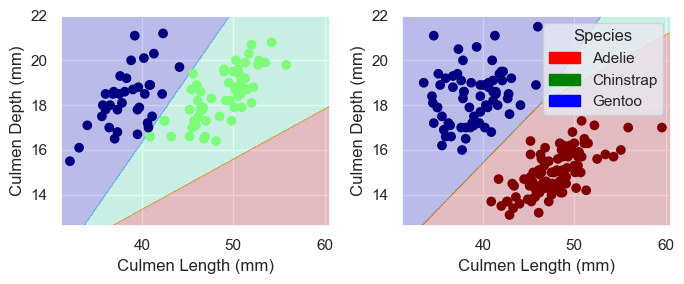

In [37]:
from plot_regions import plot_regions

import warnings
warnings.filterwarnings("ignore")

# Create column that is the opposite of "Island_Dream" in order to plot regions
not_Island_Dream = X_train[["Island_Biscoe", "Island_Torgersen"]].sum(axis=1)
X_train["Island_Dream_No"] = not_Island_Dream

cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Dream", "Island_Dream_No"]

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
score = LR.score(X_train[cols], y_train)

warnings.filterwarnings("default", category=FutureWarning)

print(score)

plot_regions(LR, X_train[cols], y_train)

Because the data is linearly seperable, we are able to reach a score of 1.0. It is also important to note that the data does not seem to be overfit. I think for this reason, linear regression without feature mapping is probably a good choice for a model as it does not "hug" the data. Furthermore, the data seems to be shaped in blobs that can be roughly seperated by linear decision boundries.

# Test Data

Finaly, I am going to test to the model on our testing data. I loadd and prepared the data similarly to the training data, ran it thorugh the logistic regression model, then showed the score and plots of this data.

0.9852941176470589


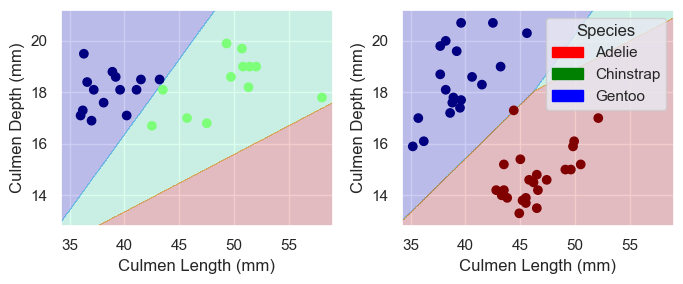

In [38]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

not_Island_Dream = X_test[["Island_Biscoe", "Island_Torgersen"]].sum(axis=1)
X_test["Island_Dream_No"] = not_Island_Dream

score = LR.score(X_test[cols], y_test)
print(score)

plot_regions(LR, X_test[cols], y_test)

With a score of roughly 98%, this model is very acurate. We can see that the model likely did not overfit to the training data beause it only incorrectly predicted one penguin that was just above the decesion line for it's correct species.